# Capstone Project 2

The dataset we will be using for the project is called the Toxic Comment Challenge from Kaggle. This is a competition in 2017 aiming to classify Wikipedia comments as one of the 6 categories: toxic, severe_toxic, obscene, threat, insult, identity_hate. This is a multi-label classification problem as we can have more than 1 label for one comment.

## I. Dataset Import

In [1]:
#Import the necessary modules
import pandas as pd
import string
from string import digits
import os
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib_venn import venn3
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
#import the training data
traindata = pd.read_csv('train.csv')

In [3]:
#Reading both datasets, notice that the testdata dataset has the comment_text
#and the testwithlabels set have all the labels
testdata = pd.read_csv('test.csv')
testwithlabels = pd.read_csv('test_labels.csv')

In [4]:
traindata.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
testwithlabels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
testdata.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
#We will now combine both testdata and testwithlabels for the final test dataset
testwithlabels['comment_text'] = testdata['comment_text']

 - As we notice from the testdata, there are some rows with values of -1, those are the one not included in the scoring system to avoid hand labelling from the Kaggle competition. For the purpose of this project. We will drop those comments with values of -1 in labelling in order to get the best predicted score.

In [8]:
#dropping all the rows with -1 values
testwithlabels = testwithlabels[testwithlabels['toxic']!=-1]
testwithlabels = testwithlabels[['id','comment_text','toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
testwithlabels

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


 - As we notice from the information above, there is no more rows in the testdata with values of -1 for scoring.

<b>Initial observations of the datasets are:</b>
 - Each comment is identified by an unique ID
 - We have 159,571 comments in the traindata and 63,978 comments in the testdata.
 - This is a text classification problem.
 - All of the columns of toxicity labelling: toxic, severe_toxic, obscene, threat, insult, identity_hate are our target variables for prediction and the text of the comments will be used as feature variable.
 - Target variables (the labels) are identified by binary code (0 and 1) and those that are 0 in all toxicity labels are considered clean comments.

## II. Exploratory Data Visualization

<b>Checking for null values</b>

In [9]:
print("Checking for null values in the Train set")
null_check=traindata.isnull().sum()
print(null_check)
print("Checking for null value in the Test set")
null_check=testwithlabels.isnull().sum()
print(null_check)

Checking for null values in the Train set
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Checking for null value in the Test set
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


 - As expected, since this is a Kaggle contest data, there is not any null value in either sets.

<b>Now we will have a look at the number of comments that are actually clean (free of toxic material)</b>

In [10]:
counttoxic = traindata[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

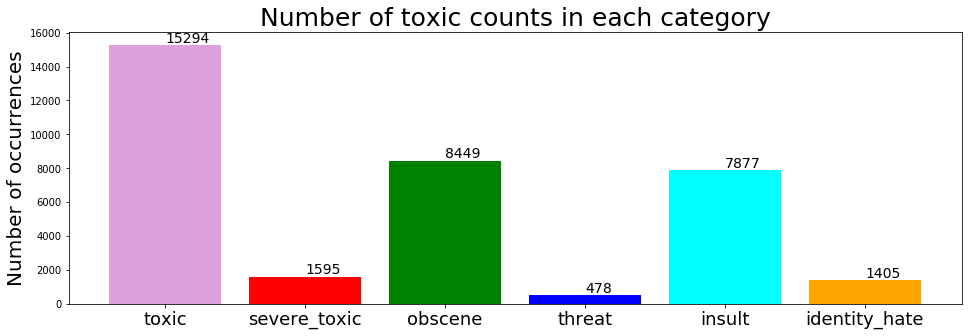

In [11]:
plt.figure(figsize=(16,5))
plt.bar(counttoxic.columns, counttoxic.sum(), color=['plum', 'red', 'green', 'blue', 'cyan', 'orange'])
plt.title('Number of toxic counts in each category', fontsize=25)
plt.ylabel('Number of occurrences', fontsize=20)
xlocs=plt.xticks(fontsize=18)
for i, v in enumerate(counttoxic.sum()):
    plt.text(s= str(v), x = i, y=v+150, fontsize=14)
plt.show()

 - Of all the toxic comments, toxic label accounts for the most with 15,294 comments and threat is a labelling class with the least number of comment (478)
 - There is an issue of imbalance among the toxic counts

<b>Create a new column for clean comments</b>

In [12]:
#The clean comment will be the one where it does not belong to any of the 6 categories
traindata['clean'] = 1 - traindata[traindata.columns[2:]].max(axis =1)
traindata.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [13]:
#Create a new data frame of the categories for counting
counttoxic2 = traindata[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']]

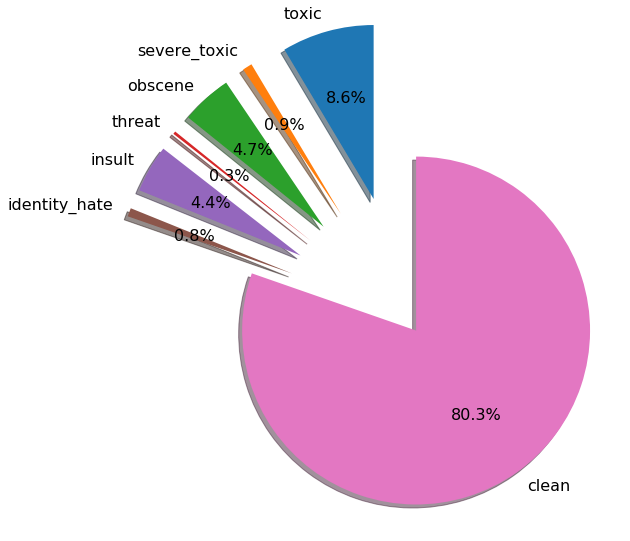

In [14]:
#Create a pie chart of the counts of different label categories
explode = (0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1)
plt.figure(figsize=(16,8))
plt.pie(counttoxic2.sum(), explode = explode, labels=counttoxic2.columns, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 16})
plt.show()

<b>Checking the Correlation between features<b>

As we can see, the 7 feature variables (including clean) are dichotomous categorical variables (with values as either 0 or 1) so we can apply the Pearson correlation (also known as point-biserial correlation coefficient) in this case. We will do a correlation heatmap in order to look at the correlation between these variables.

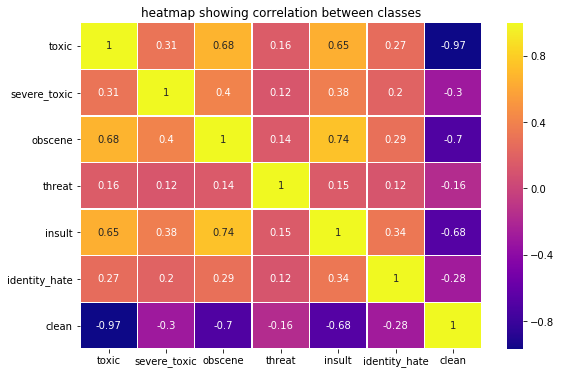

In [15]:
#Finding the correlation between feature variables
y = traindata.corr()
colormap = plt.cm.plasma
plt.figure(figsize=(9,6))
sns.heatmap(y,annot=True,linewidths=.5, cmap=colormap)
plt.title('heatmap showing correlation between classes')
plt.show()

Notice the .corr() formula simply ignore the comment_text variable as it is a non-numerical variable

 - There is high correlation between clean and toxic (negatively correlated) suggesting that the comments are likely to be classified as either toxic or clean
 - obscene and insult categories also have high correlation with toxic (0.68 and 0.65 respectively). Perhaps we can explore further with a Venn diagram to see

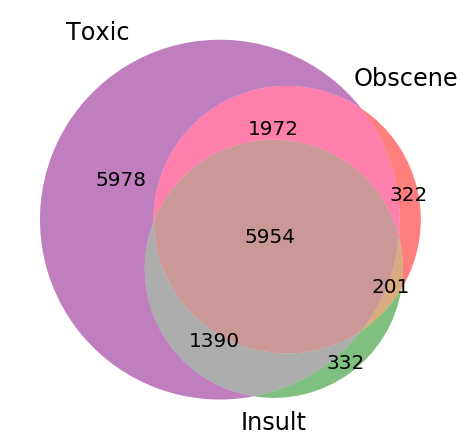

In [16]:
#We use the library for venn diagrams in order to visualize the correlation of these 3 categories
#We need to create little subsets of values corresponding to overlapping values
Set1 = len(traindata[(traindata['toxic']==1) & (traindata['obscene']==0) & (traindata['insult']==0)])
Set2 = len(traindata[(traindata['toxic']==0) & (traindata['obscene']==1) & (traindata['insult']==0)])
Set3 = len(traindata[(traindata['toxic']==1) & (traindata['obscene']==1) & (traindata['insult']==0)])
Set4 = len(traindata[(traindata['toxic']==0) & (traindata['obscene']==0) & (traindata['insult']==1)])
Set5 = len(traindata[(traindata['toxic']==1) & (traindata['obscene']==0) & (traindata['insult']==1)])
Set6 = len(traindata[(traindata['toxic']==0) & (traindata['obscene']==1) & (traindata['insult']==1)])
Set7 = len(traindata[(traindata['toxic']==1) & (traindata['obscene']==1) & (traindata['insult']==1)])
#Drawing the Venn diagram based on the data
plt.figure(figsize=(8, 8))
diagram = venn3(subsets = (Set1, Set2, Set3, Set4, Set5, Set6, Set7), 
      set_labels = ('Toxic', 'Obscene', 'Insult'),set_colors=('purple', 'red', 'green'), alpha = 0.5);
for text in diagram.set_labels:
    text.set_fontsize(24)
for text in diagram.subset_labels:
    text.set_fontsize(20)

It is interesting to note here that: 
 - The majority of comments classified as obscene are also classified as toxic (1972 + 5954 = 7926 comments out of 8449 obscene comments which is roughly 93.8%) 
 - and the majority of comments classified as insult are also classified as toxic (5954+1390=7344 comments out of the 7877 insult comments which is roughly 93.2%)
 - 5954 comments are classified as obscene, insult and toxic

<b>Checking the number of classification per comment</b>

In [17]:
traindata['Number of labels'] = traindata['toxic']+traindata['severe_toxic']+ traindata['obscene']+ traindata['threat']+ traindata['insult'] + traindata['identity_hate']

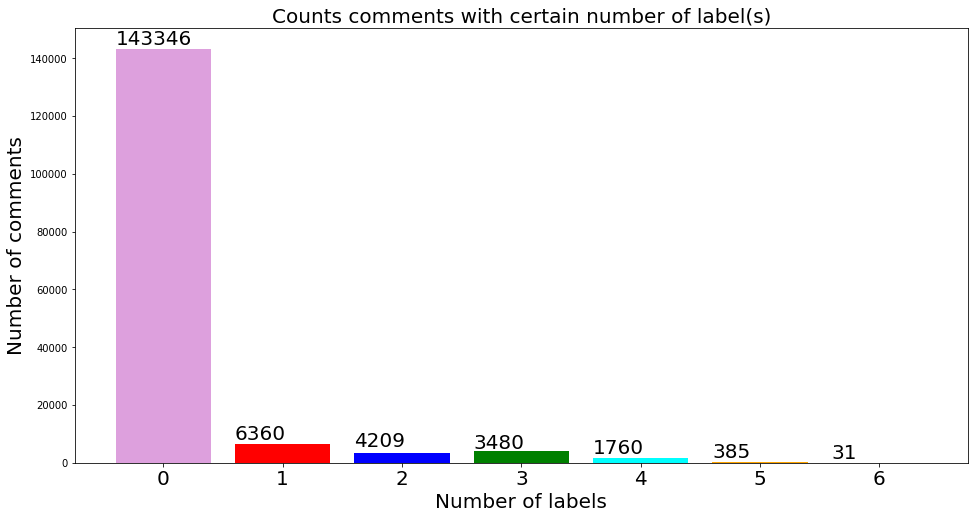

In [18]:
labelnumber = traindata['Number of labels'].value_counts()
plt.figure(figsize=(16,8))
plt.bar(labelnumber.index.values, labelnumber, color=['plum', 'red', 'green', 'blue', 'cyan', 'orange', 'indigo'])
plt.title('Counts comments with certain number of label(s)',fontsize=20)
plt.ylabel('Number of comments',fontsize=20)
plt.xlabel('Number of labels',fontsize=20)
xlocs=plt.xticks(fontsize=20)
for i, v in enumerate(labelnumber):
    plt.text(s= str(v), x = i-0.4, y=v+1500, fontsize=20)
plt.show()

 - This is a clearly imbalanced dataset with the majority of comments being clean.

### Exploring the Text Data

We will have a quick look at some of the comments in the training dataset

In [19]:
for i in [26, 30, 50,51,52]:
    display(traindata.loc[i, 'comment_text'])

"There's no need to apologize. A Wikipedia article is made for reconciling knowledge about a subject from different sources, and you've done history studies and not archaeology studies, I guess. I could scan the page, e-mail it to you, and then you could ask someone to translate the page."

"How could I post before the block expires?  The funny thing is, you think I'm being uncivil!"

'"\n\nBI, you said you wanted to talk\n\nAt the bottom of the lead section you have written:\n\n""Its promoter speculated in 1994 that the skyhook concept could be cost competitive with what is realistically thought to be achievable using a space elevator, but the skyhook is not competitive with other rotating tether concepts. In addition, the rotating skyhook is in fact deemed ""not engineeringly feasible using presently available materials"".""\n\nRegarding:  In addition, the rotating skyhook is in fact deemed ""not engineeringly feasible using presently available materials""\n\nThat statement appears to come from Ref [3] on page 10.  The full quote is\n\n""If the mass of the tether alone started to exceed 200 times the mass of the payload,\nthen that was an indication the particular scenario being considered was not engineeringly\nfeasible using presently available materials, although the application might become feasible in\nthe near future as better materials become available with

"GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!"

"Are you threatening me for disputing neutrality? I know in your country it's quite common to bully your way through a discussion and push outcomes you want. But this is not Russia."

 - As we can see from the sample comments above, the length of each comment varies and there are many non-word characters.
<p><b>We will further explore the distribution of the comment lengths</b></p>

In [20]:
comment_length = traindata['comment_text'].str.len()
print('Characteristics of the general distribution of comment lengths:\n', comment_length.describe())

Characteristics of the general distribution of comment lengths:
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64


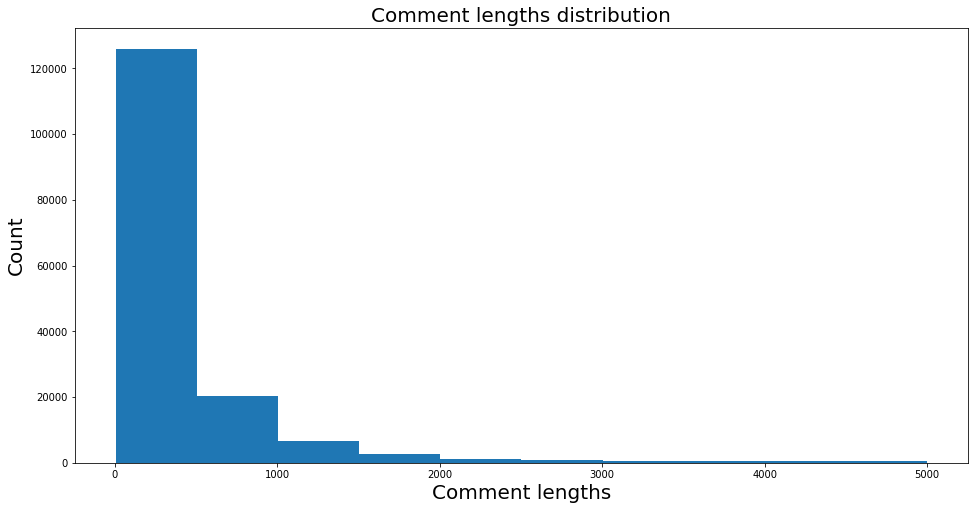

In [21]:
plt.figure(figsize=(16,8))
plt.hist(comment_length)
plt.title('Comment lengths distribution',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xlabel('Comment lengths',fontsize=20)
plt.show()

 - There is no empty comment as the min length is 6
 - The comment length varies but most of the comment lengths fall below 1000
 - The histogram show skewness to the left with a mean of 394 characters

## III. Data Cleaning

<b>Combining the comment from traindata and testdata for text cleaning<b>

In [22]:
#Setting ID as the index for traindata and test data
traindata = traindata.set_index('id')
testwithlabels = testwithlabels.set_index('id')
#Extracting comment_text from the traindata
train_comments = traindata['comment_text']
#Extracting comment_text from the traindata
test_comments = testwithlabels['comment_text']
#saving the index for later separation
train_comments_index = train_comments.index
test_comments_index = test_comments.index

In [23]:
#concat the train comments and the test comments for text cleaning
frames = [train_comments, test_comments]
comments = pd.concat(frames)

In [24]:
#Removing the punctuation:
comments=comments.str.translate(str.maketrans(' ', ' ', string.punctuation))
#Removing the \n in the comments
comments=comments.str.translate(str.maketrans(' ', ' ', '\n'))
#removing the digits in the comments
comments=comments.str.translate(str.maketrans(' ', ' ', digits))
#Splitting combined words
comments=comments.apply(lambda tweet: re.sub(r'([a-z])([A-Z])',r'\1 \2',tweet))
#Converting words into lowercase
comments=comments.str.lower()

In [25]:
#tokenize comments
comments_token = comments.apply(word_tokenize)

In [26]:
#Setting stopwords
stop = set(stopwords.words('english'))
#removing stopwords
comments_token = comments_token.apply(lambda x: [item for item in x if item not in stop])
comments_token.head() 

id
0000997932d777bf    [explanation, edits, made, username, hardcore,...
000103f0d9cfb60f    [daww, matches, background, colour, im, seemin...
000113f07ec002fd    [hey, man, im, really, trying, edit, war, guy,...
0001b41b1c6bb37e    [cant, make, real, suggestions, improvement, w...
0001d958c54c6e35           [sir, hero, chance, remember, page, thats]
Name: comment_text, dtype: object

In [27]:
#Converting words in base form/lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
comments_token = comments_token.apply(lemmatize_text)
comments_token.head()

id
0000997932d777bf    [explanation, edits, made, username, hardcore,...
000103f0d9cfb60f    [daww, match, background, colour, im, seemingl...
000113f07ec002fd    [hey, man, im, really, trying, edit, war, guy,...
0001b41b1c6bb37e    [cant, make, real, suggestion, improvement, wo...
0001d958c54c6e35           [sir, hero, chance, remember, page, thats]
Name: comment_text, dtype: object

In [28]:
#Split the data in clean training data and clean test data
train_token = comments_token.loc[train_comments_index]
test_clean_data = comments.loc[test_comments_index]
train_clean_data = comments.loc[train_comments_index]

In [29]:
#Adding the original labels into the data
labelstest=testwithlabels.iloc[:,1:]
labelstrain=traindata.iloc[:,1:]
train_token = pd.concat([train_token,labelstrain],axis=1)

In [30]:
train_token

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,Number of labels
id,,,,,,,,,
0000997932d777bf,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0,1,0
000103f0d9cfb60f,"[daww, match, background, colour, im, seemingl...",0,0,0,0,0,0,1,0
000113f07ec002fd,"[hey, man, im, really, trying, edit, war, guy,...",0,0,0,0,0,0,1,0
0001b41b1c6bb37e,"[cant, make, real, suggestion, improvement, wo...",0,0,0,0,0,0,1,0
0001d958c54c6e35,"[sir, hero, chance, remember, page, thats]",0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
ffe987279560d7ff,"[second, time, asking, view, completely, contr...",0,0,0,0,0,0,1,0
ffea4adeee384e90,"[ashamed, horrible, thing, put, talk, page]",0,0,0,0,0,0,1,0
ffee36eab5c267c9,"[spitzer, umm, there, actual, article, prostit...",0,0,0,0,0,0,1,0


<b>Generating Word Cloud for each categories of toxicity<b>

In [31]:
#Generating WordCloud after the initial data cleaning and lemmatization
wc = WordCloud()

In [32]:
#Create a dictionary of word frequency count in each of the toxic labels
word_frequency = {}
labelnames = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#Looping over 
for label in labelnames:
    d=Counter()
    train_token[train_token[label]==1]['comment_text'].apply(lambda t: d.update(t))
    word_frequency[label] = pd.DataFrame.from_dict(d, orient='index').rename(columns={0: 'count'}).sort_values('count', ascending=False)

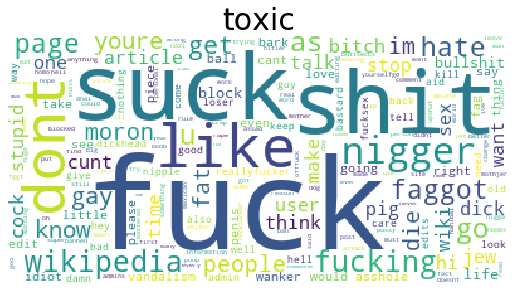

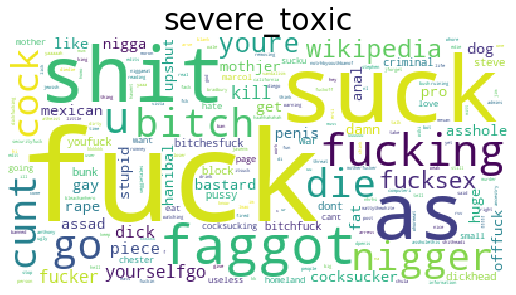

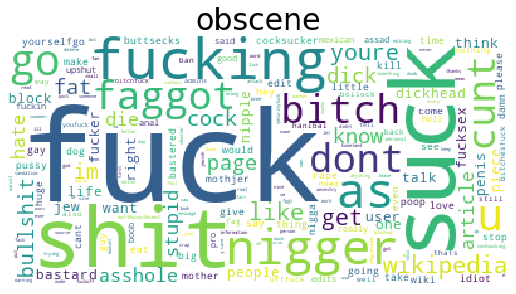

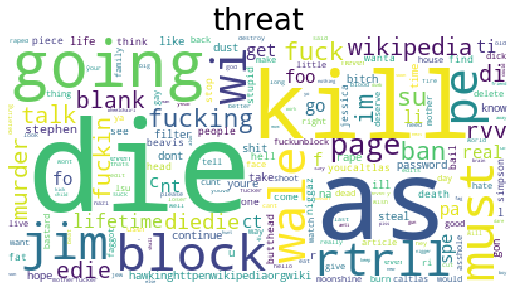

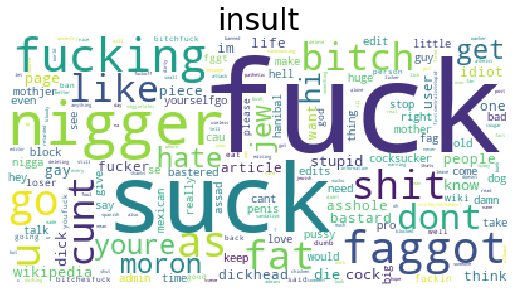

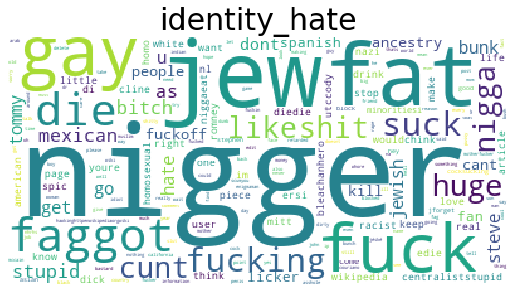

In [33]:
#Create Word Cloud for each category
for labelcount in word_frequency:
    lc = word_frequency[labelcount]

    wordcloud = WordCloud(
          background_color='white',
          max_words=200,
          max_font_size=100, 
         ).generate_from_frequencies(lc.to_dict()['count'])

    fig = plt.figure(figsize=(9, 6))
    plt.title(labelcount,fontsize=30)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

## Data Preprocessing

In [34]:
train_clean_data=pd.concat([train_clean_data,labelstrain],axis=1)
test_clean_data=pd.concat([test_clean_data, labelstest], axis=1)
train_clean_data = train_clean_data.drop(columns=['Number of labels','clean'])
train_clean_data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0
0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0
ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0


In [35]:
test_clean_data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0
000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
0003e1cccfd5a40a,it says it right there that it is a type the...,0,0,0,0,0,0
00059ace3e3e9a53,before adding a new product to the list mak...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
fff8f64043129fa2,jerome i see you never got around to this… i’m...,0,0,0,0,0,0
fff9d70fe0722906,lucky bastard httpwikimediafoundationorgwiki ...,0,0,0,0,0,0
fffa8a11c4378854,shame on you all you want to speak about gays...,0,0,0,0,0,0


## IV. Modelling: Approaching the data set as a competition

In this approach, we only train the model using the train dataset and then we will make prediction on the testset. We will then evaluate the score on the test set to get the accuracy score result.

### Choosing evaluation metrics

As we notice from the EDA. This dataset is very imbalanced with 80.3% of the data clean and the remaining classified in one of the labels. That means if we predict everything as clean we have a 80.3% of accuracy rate. In that instance, it is more appropriate to use ROC-AUC score as evaluation metric. This value is averaged out across 6 labels to find the best model.

### Tuning the models

Since the dataset is too large to carry out GridSearchCV, we will implement testing the model on different parameters to see which parameters performs best.

### Splitting the training data into train and validation sets

We will split the training set into training and validation sets (we use validation in order to differentiate with the actual test data)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(train_clean_data['comment_text'], 
                                                  train_clean_data[labelnames], test_size=0.33, random_state=2019)
X_test = test_clean_data['comment_text']
y_test = test_clean_data[labelnames]

## Vectorize the Data

As we can see this is a multiclass-multioutput classification problem because there are more than one possible option for 

#### Vectorize the Data using TfidfVectorizer

In [37]:
# import and instantiate TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range = (1,2), min_df = 9, strip_accents='unicode', analyzer='word',
                        use_idf=1, smooth_idf=1, sublinear_tf=1,stop_words = 'english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=9, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [38]:
#Vectorize both the dataset and the testset using TfidfVectorizer
tfidf.fit(pd.concat([train_clean_data['comment_text'],test_clean_data['comment_text']]))
#transforming the X training set
X_train_tf = tfidf.transform(X_train)
#transforming the X validation set
X_val_tf = tfidf.transform(X_val)
#transforming the test set
X_test_tf = tfidf.transform(X_test)

#### Vectorize the Data using CounVectorizer

In [39]:
Countvect = CountVectorizer()
#Vectorize both the dataset and the testset using CountVectorizer
Countvect.fit(pd.concat([train_clean_data['comment_text'],test_clean_data['comment_text']]))
#Vectorize the Data using CountVectorizer
X_train_CV = Countvect.transform(X_train)
X_val_CV = Countvect.transform(X_val)
X_test_CV = Countvect.transform(X_test)

### Functions

## Model 1: Logistic Regression

### A. Using TFIDF Data

Given the fact that we have a multi-label classification problem (there are 6 labels and each comment can be classified as either none-CLEAN or up to 6 labels), there are two options of training:
 - <b>OneVsRestClassifier</b>: putting this classifier outside a classifier approach each label as an individual classification problem
 - <b>ClassifierChain</b>: using this classifier helps us predict the labels based on the previously trained labels (meaning the order of the labels matter and say we train the model for toxic label first, then the other label of 'severe toxic', 'obscene' and etc. are also trained based on previously trained models. As we identify above, there are some correlations among the labels, perhaps training the model using ClassifierChain could generate better result than OneVsRestClassifier

### With OneVsRestClassifier

In [40]:
def Average(lst): 
    return sum(lst) / len(lst) 
logreg1 = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg1.fit(X_train_tf, y_train)
prediction = logreg1.predict_proba(X_val_tf)
ROC1=list(roc_auc_score(y_val, prediction, average=None))
ROC1.append(Average(ROC1))
df = pd.DataFrame(list(ROC1), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

,ROCAUC
toxic,0.968258
severe_toxic,0.984863
obscene,0.981258
threat,0.979104
insult,0.971562
identity_hate,0.970317
average,0.975894


### With ClassifierChain

In [41]:
logreg2 = ClassifierChain(LogisticRegression(solver='sag'))
logreg2.fit(X_train_tf, y_train)
prediction = logreg2.predict_proba(X_val_tf)
ROC2=list(roc_auc_score(y_val, prediction, average=None))
ROC2.append(Average(ROC2))
df = pd.DataFrame(list(ROC2), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

,ROCAUC
toxic,0.968258
severe_toxic,0.980751
obscene,0.970786
threat,0.965633
insult,0.947265
identity_hate,0.955580
average,0.964712


Of the 2 classifiers for Logistic Regression as the estimator, OneVsRestClassifier gives us better result than ClassifierChain.

### A1. Model Tuning for Logistic Regression

In [42]:
print('GRIDSEARCH RESULTs FOR LOGISTIC REGRESSION')
log_regCV = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
parametersLG = [{'estimator__C': [100, 10, 1, 0.1],'estimator__penalty' : ['l1', 'l2']}]
# define grid search
grid_search = GridSearchCV(estimator=log_regCV, param_grid=parametersLG, cv=5, n_jobs=-1, scoring='roc_auc')
grid_result = grid_search.fit(X_train_tf, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
        

GRIDSEARCH RESULTs FOR LOGISTIC REGRESSION
Best: 0.977498 using {'estimator__C': 1, 'estimator__penalty': 'l2'}
0.938992 (0.002794) with: {'estimator__C': 100, 'estimator__penalty': 'l1'}
0.961769 (0.002480) with: {'estimator__C': 100, 'estimator__penalty': 'l2'}
0.960578 (0.002938) with: {'estimator__C': 10, 'estimator__penalty': 'l1'}
0.974153 (0.001846) with: {'estimator__C': 10, 'estimator__penalty': 'l2'}
0.966114 (0.002493) with: {'estimator__C': 1, 'estimator__penalty': 'l1'}
0.977498 (0.001735) with: {'estimator__C': 1, 'estimator__penalty': 'l2'}
0.868341 (0.008439) with: {'estimator__C': 0.1, 'estimator__penalty': 'l1'}
0.971639 (0.002118) with: {'estimator__C': 0.1, 'estimator__penalty': 'l2'}


 - Based on parameter tuning based on the accuracy score, the best parameters for logistic regression would be C=1, penalty=l1

<b>Model Tuning based on ROC-AUC</b>

As we notice from above, the C values for both accuracy and ROC-AUC are the same but for penalty of l2, we achieve a highest value of ROC-AUC. We will therefore choose C=1 and penalty='l2' as the parameters for our final logistic regression model.

<b>Final Logistic Regression for TFIDF Data<b>

In [43]:
final_logreg = OneVsRestClassifier(LogisticRegression(solver='liblinear', C=1, penalty='l2'))
final_logreg.fit(X_train_tf, y_train)
#Make prediction on the validation set
predictionLOG=final_logreg.predict_proba(X_val_tf)
val_LOG = roc_auc_score(y_val, predictionLOG)

print(val_LOG)

0.975948853703887


 - There is a slight improvement in validation data accuracy after we set the C value and penalty value. Technically, we only altered the penalty value as the default C value is already 1.

<b>Fitting the data on the Test dataset</b>

In [44]:
#Making prediction on the X_test
predictionLOG_test=final_logreg.predict_proba(X_test_tf)
print(roc_auc_score(y_test, predictionLOG_test))

0.972933293198082


As we notice, the model performs really well on both the validation set and the test set with a slightly better performance on the validation set. Nevertheless the model performs quite well.

<b>Converting the model to vectorize words and characters<b>: We will test the model using both words and characters vectorizer to see if the model performs better

In [45]:
from sklearn.pipeline import make_union
char_vectorizer = TfidfVectorizer(ngram_range =(1,4),
                                 min_df=3, max_df=0.9,
                                 strip_accents='unicode',
                                 analyzer = 'char',
                                 stop_words = 'english',
                                 use_idf=1,
                                 smooth_idf=1,
                                 sublinear_tf=1,
                                 max_features=50000)
vectorizer = make_union(tfidf, char_vectorizer)

In [46]:
#fitting the model on the whole dataset
vectorizer.fit(pd.concat([train_clean_data['comment_text'],test_clean_data['comment_text']]))

FeatureUnion(n_jobs=None,
             transformer_list=[('tfidfvectorizer-1',
                                TfidfVectorizer(analyzer='word', binary=False,
                                                decode_error='strict',
                                                dtype=<class 'numpy.float64'>,
                                                encoding='utf-8',
                                                input='content', lowercase=True,
                                                max_df=1.0, max_features=None,
                                                min_df=9, ngram_range=(1, 2),
                                                norm='l2', preprocessor=None,
                                                smooth_idf=1,
                                                stop_words='english',
                                                strip_accents='unicode',...
                                                dtype=<class 'numpy.float64'>,
                       

In [47]:
#Transforming the dataset
X_train_tf2 = vectorizer.transform(X_train)
X_val_tf2 = vectorizer.transform(X_val)
X_test_tf2 = vectorizer.transform(X_test)

In [73]:
words=vectorizer.get_feature_names()

<b>Running the model on the dataset containing both characters and words vectorizer<b>

In [48]:
final_logreg2 = OneVsRestClassifier(LogisticRegression(solver='liblinear', C=1, penalty='l2'))
final_logreg2.fit(X_train_tf2, y_train)
#Running the model on the validation set
predictionLOG2=final_logreg2.predict_proba(X_val_tf2)
val_LOG2 = roc_auc_score(y_val, predictionLOG2)

print(val_LOG2)

0.9831705450311888


In [49]:
#Making prediction on the X_test
predictionLOG_test2=final_logreg2.predict_proba(X_test_tf2)
print(roc_auc_score(y_test, predictionLOG_test2))

0.9793388719611965


The model does better in the dataset containing both words and characters vectorizer as opposed to only word vectorizer.

### B. Using CountVectorizer Data

We will run the model on CountVectorizer dataset so see if it performs better than the TFIDF dataset.

In [50]:
logreg1CV = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg1CV.fit(X_train_CV, y_train)
prediction = logreg1CV.predict_proba(X_val_CV)
ROC_1CV=list(roc_auc_score(y_val, prediction, average=None))
ROC_1CV.append(Average(ROC_1CV))
df = pd.DataFrame(list(ROC_1CV), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

/Users/sieusaominhngoc/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,ROCAUC
toxic,0.799235
severe_toxic,0.765841
obscene,0.778556
threat,0.619170
insult,0.774192
identity_hate,0.671779
average,0.734796


As we notice from the accuracy score above, TFIDF Data seems to perform better than CountVectorizer Data.

## Model 2: Naive Bayes

The 2nd model we will train the dataset on is the Naive Bayes model.

In [51]:
from sklearn.naive_bayes import MultinomialNB
NBmodel = OneVsRestClassifier(MultinomialNB())
NBmodel.fit(X_train_tf2, y_train)
print('Model with TFIDF data: Naive Bayes')
predictionNB = NBmodel.predict_proba(X_val_tf2)
ROCNB=list(roc_auc_score(y_val, predictionNB, average=None))
ROCNB.append(Average(ROCNB))
df = pd.DataFrame(list(ROCNB), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF data: Naive Bayes


,ROCAUC
toxic,0.917575
severe_toxic,0.907838
obscene,0.909895
threat,0.778530
insult,0.906106
identity_hate,0.819404
average,0.873225


### Hyper-parameters tuning

In [52]:
BayesModel = OneVsRestClassifier(MultinomialNB())
parametersB = [{'estimator__alpha': [.1, 1, 5, 10, 50]}]
# define grid search
grid_searchBayes = GridSearchCV(estimator=BayesModel, param_grid=parametersB, n_jobs=-1, scoring='roc_auc')
grid_resultBayes = grid_searchBayes.fit(X_train_tf2, y_train)
# summarize results
print("Best: %f using %s" % (grid_resultBayes.best_score_, grid_resultBayes.best_params_))
means = grid_resultBayes.cv_results_['mean_test_score']
stds = grid_resultBayes.cv_results_['std_test_score']
params = grid_resultBayes.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/sieusaominhngoc/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.943539 using {'estimator__alpha': 0.1}
0.943539 (0.004337) with: {'estimator__alpha': 0.1}
0.853696 (0.005620) with: {'estimator__alpha': 1}
0.781917 (0.006313) with: {'estimator__alpha': 5}
0.762324 (0.006495) with: {'estimator__alpha': 10}
0.737935 (0.006715) with: {'estimator__alpha': 50}


In [53]:
final_Bayes = OneVsRestClassifier(MultinomialNB(alpha=0.1))
final_Bayes.fit(X_train_tf2, y_train)
print('Final model with TFIDF dataset: Naive Bayes')
predictionBayes = final_Bayes.predict_proba(X_val_tf2)
ROC_Bayes=list(roc_auc_score(y_val, predictionBayes, average=None))
ROC_Bayes.append(Average(ROC_Bayes))
df = pd.DataFrame(list(ROC_Bayes), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Final model with TFIDF dataset: Naive Bayes


,ROCAUC
toxic,0.954660
severe_toxic,0.973322
obscene,0.958055
threat,0.912945
insult,0.957876
identity_hate,0.933435
average,0.948382


In [54]:
final_BayesCV = OneVsRestClassifier(MultinomialNB(alpha=0.1))
final_BayesCV.fit(X_train_CV, y_train)
print('Final model with CountVectorize dataset: Naive Bayes')
predictionBayesCV = final_BayesCV.predict_proba(X_val_CV)
ROC_BayesCV=list(roc_auc_score(y_val, predictionBayesCV, average=None))
ROC_BayesCV.append(Average(ROC_BayesCV))
df = pd.DataFrame(list(ROC_BayesCV), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Final model with CountVectorize dataset: Naive Bayes


,ROCAUC
toxic,0.917226
severe_toxic,0.929333
obscene,0.919417
threat,0.848131
insult,0.916570
identity_hate,0.864621
average,0.899216


Similarly with Logistic Regression, the model performs better with TFIDF data compared to CountVectorize data.

### Running the model on the Test Set

In [55]:
#Making prediction on the X_test
predictionBayes_test2=final_Bayes.predict_proba(X_test_tf2)
print(roc_auc_score(y_test, predictionBayes_test2))

0.9364384235442692


The model performs quite well but not as good as Logistic Regression

## Model 3: Decision Tree Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier
DTmodel = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10))
DTmodel.fit(X_train_tf2, y_train)
print('Model with TFIDF dataset: Decision Tree (default gini criterion)')
predictionDT = DTmodel.predict_proba(X_val_tf2)
ROCDT=list(roc_auc_score(y_val, predictionDT, average=None))
ROCDT.append(Average(ROCDT))
df = pd.DataFrame(list(ROCDT), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF dataset: Decision Tree (default gini criterion)


,ROCAUC
toxic,0.740011
severe_toxic,0.805550
obscene,0.841200
threat,0.614732
insult,0.766586
identity_hate,0.747754
average,0.752639


Trying the model with criterion='entropy'

In [57]:
DTmodel2 = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10, criterion='entropy'))
DTmodel2.fit(X_train_tf2, y_train)
print('Model with TFIDF dataset: Decision Tree with entropy criterion')
predictionDT2 = DTmodel2.predict_proba(X_val_tf2)
ROCDT2=list(roc_auc_score(y_val, predictionDT2, average=None))
ROCDT2.append(Average(ROCDT2))
df = pd.DataFrame(list(ROCDT2), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF dataset: Decision Tree with entropy criterion


,ROCAUC
toxic,0.841011
severe_toxic,0.736647
obscene,0.858569
threat,0.703729
insult,0.843947
identity_hate,0.769022
average,0.792154


In [58]:
finalDTCV = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10,criterion='entropy'))
finalDTCV.fit(X_train_CV, y_train)
print('Model with CountVectorizer dataset: Decision Tree')
prediction_DTCV = finalDTCV.predict_proba(X_val_CV)
ROC_DTCV=list(roc_auc_score(y_val, prediction_DTCV, average=None))
ROC_DTCV.append(Average(ROC_DTCV))
df = pd.DataFrame(list(ROC_DTCV), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with CountVectorizer dataset: Decision Tree


,ROCAUC
toxic,0.788924
severe_toxic,0.800206
obscene,0.862610
threat,0.719132
insult,0.836273
identity_hate,0.780570
average,0.797953


In [59]:
finalDTCV3 = ClassifierChain(DecisionTreeClassifier(max_depth=10,criterion='entropy'))
finalDTCV3.fit(X_train_CV, y_train)
print('Testing the model using ClassifierChain instead of OneVsRest: Decision Tree')
prediction_DTCV3 = finalDTCV3.predict_proba(X_val_CV)
ROC_DTCV3=list(roc_auc_score(y_val, prediction_DTCV3, average=None))
ROC_DTCV3.append(Average(ROC_DTCV3))
df = pd.DataFrame(list(ROC_DTCV3), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Testing the model using ClassifierChain instead of OneVsRest: Decision Tree


,ROCAUC
toxic,0.788485
severe_toxic,0.823473
obscene,0.830148
threat,0.558249
insult,0.836210
identity_hate,0.659727
average,0.749382


The model seems to do less effective with ClassifierChain than OneVsRestClassifier

In [60]:
#Testing the model on max_depth=15
finalDTCV2 = OneVsRestClassifier(DecisionTreeClassifier(max_depth=15,criterion='entropy'))
finalDTCV2.fit(X_train_CV, y_train)
print('Final model with max_depth = 15: Decision Tree')
prediction_DTCV2 = finalDTCV2.predict_proba(X_val_CV)
ROC_DTCV2=list(roc_auc_score(y_val, prediction_DTCV2, average=None))
ROC_DTCV2.append(Average(ROC_DTCV2))
df = pd.DataFrame(list(ROC_DTCV2), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Final model with max_depth = 15: Decision Tree


,ROCAUC
toxic,0.827153
severe_toxic,0.684435
obscene,0.858615
threat,0.680063
insult,0.822210
identity_hate,0.777247
average,0.774954


### Running the model on the Test set

Based on the running of different model parameters, we find that Decision Tree Classifier seems to do best with OneVsRestClassifier, max_depth=10, criterion='entropy' and it performs better on CountVectorizer dataset compared with TFIDF dataset. We will therefore make prediction on the Test set as below.

In [61]:
#Making prediction on the X_test
predictionDT_test2=finalDTCV.predict_proba(X_test_CV)
print(roc_auc_score(y_test, predictionDT_test2))

0.7940876156701954


## Model 4: Random Forest Classifier

In [62]:
from sklearn.ensemble import RandomForestClassifier 
RFmodel = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100, max_depth=15))
RFmodel.fit(X_train_tf2, y_train)
print('Model with TFIDF and OneVsRestClassifier: Random Forest Classifier')
predictionRF = RFmodel.predict_proba(X_val_tf2)
ROCRF=list(roc_auc_score(y_val, predictionRF, average=None))
ROCRF.append(Average(ROCRF))
df = pd.DataFrame(list(ROCRF), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF and OneVsRestClassifier: Random Forest Classifier


,ROCAUC
toxic,0.933500
severe_toxic,0.979556
obscene,0.976782
threat,0.921531
insult,0.960064
identity_hate,0.946986
average,0.953070


In [63]:
#Using ClassifierChain
RFmodel2 = ClassifierChain(RandomForestClassifier(n_estimators = 100, max_depth=15))
RFmodel2.fit(X_train_tf2, y_train)
print('Model with TFIDF and ClassifierChain: Random Forest Classifier')
predictionRF2 = RFmodel2.predict_proba(X_val_tf2)
ROCRF2=list(roc_auc_score(y_val, predictionRF2, average=None))
ROCRF2.append(Average(ROCRF2))
df = pd.DataFrame(list(ROCRF2), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF and ClassifierChain: Random Forest Classifier


,ROCAUC
toxic,0.933731
severe_toxic,0.977144
obscene,0.974873
threat,0.928160
insult,0.959790
identity_hate,0.948915
average,0.953769


In [64]:
RFmodelCV = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100, max_depth=15))
RFmodelCV.fit(X_train_CV, y_train)
print('Model with CountVectorizer datasets: Random Forest')
predictionRFCV = RFmodelCV.predict_proba(X_val_CV)
ROCRFCV=list(roc_auc_score(y_val, predictionRFCV, average=None))
ROCRFCV.append(Average(ROCRFCV))
df = pd.DataFrame(list(ROCRFCV), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with CountVectorizer datasets: Random Forest


,ROCAUC
toxic,0.920494
severe_toxic,0.973829
obscene,0.963179
threat,0.928774
insult,0.943864
identity_hate,0.934240
average,0.944063


### Hyper parameter tuning

In [65]:
#testing the model with n_estimators=1000
RFmodel3 = OneVsRestClassifier(RandomForestClassifier(n_estimators = 1000, max_depth=15))
RFmodel3.fit(X_train_tf2, y_train)
print('Model with TFIDF and OneVsRestClassifier: Random Forest Classifier')
predictionRF3 = RFmodel3.predict_proba(X_val_tf2)
ROCRF3=list(roc_auc_score(y_val, predictionRF3, average=None))
ROCRF3.append(Average(ROCRF3))
df = pd.DataFrame(list(ROCRF3), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF and OneVsRestClassifier: Random Forest Classifier


,ROCAUC
toxic,0.936943
severe_toxic,0.982700
obscene,0.979460
threat,0.951529
insult,0.963969
identity_hate,0.961600
average,0.962700


In [66]:
#testing the model with n_estimators =1000 and max_depth =10
RFmodel4 = OneVsRestClassifier(RandomForestClassifier(n_estimators = 1000, max_depth=10))
RFmodel4.fit(X_train_tf2, y_train)
print('Model with TFIDF and OneVsRestClassifier: Random Forest Classifier')
predictionRF4 = RFmodel4.predict_proba(X_val_tf2)
ROCRF4=list(roc_auc_score(y_val, predictionRF4, average=None))
ROCRF4.append(Average(ROCRF4))
df = pd.DataFrame(list(ROCRF4), columns=['ROCAUC'], 
                      index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'average'])
df

Model with TFIDF and OneVsRestClassifier: Random Forest Classifier


,ROCAUC
toxic,0.925093
severe_toxic,0.981119
obscene,0.974446
threat,0.950142
insult,0.957683
identity_hate,0.956791
average,0.957546


In [67]:
#Making prediction on the X_test for RF model3
predictionRF_test=RFmodel3.predict_proba(X_test_tf2)
print(roc_auc_score(y_test, predictionRF_test))

0.9668089908285783
